## Gender Classification with Kernelized Perceptron using First Names

In [1]:
# import all the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Read the dataset
df = pd.read_csv("../../assets/data/gender.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1294 entries, 0 to 1293
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Name    1294 non-null   object
 1   Target  1294 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 20.3+ KB


In [4]:
df.head()

,Name,Target
0,Yash,1
1,Prit,1
2,Meet,1
3,Drashti,0
4,Saloni,0


In [5]:
# Convert each name to feature vector
X = []
y = []

# Considering the last character, unigrams, and bigrams in name
# num_feats = 26 + 26*26 + 26*26*26 + 1  # 26 letters + 26*26 bigrams + 26*26*26 Trigrams + 1 bias
num_feats = 26 + 26*26 + 1  # 26 letters + 26*26 bigrams + 1 bias

for i in range(len(df)):
    name = df.iloc[i]['Name']
    target = df.iloc[i]['Target']
    name = name.lower()

    vec = np.zeros(num_feats)
    vec[num_feats-1] = 1   # Initialize bias term as 1

    # Consider last character of name
    vec[ord(name[-1]) - 97] += 1

    # Consider all bigrams
    for j in range(len(name)-1):
        bigram = name[j:j+2]
        index = 26 + (ord(bigram[0]) - 97)*26 + (ord(bigram[1]) - 97)
        vec[index] += 1

    # # Consider all trigrams
    # for k in range(len(name)-2):
    #     trigram = name[k:k+3]
    #     index = 26*26 + (ord(trigram[0]) - 97)*26*26 + (ord(trigram[1]) - 97)*26 + (ord(trigram[2]) - 97)
    #     vec[index] += 1

    X.append(vec)

    if target == 0:
        # -1 represents girl
        y.append(-1)
    else:
        # 1 represents boy
        y.append(1)

# Printing sample feature vector and label
print(X[0].shape)
print(y[0])


(703,)
1


In [6]:
# Split data into train, val and test sets
test_size = 0.1
val_size = 0.1

data = list(zip(X, y))

split_index1 = int(len(data) * (1 - test_size - val_size))
split_index2 = int(len(data) * (1 - test_size))
train_data = data[:split_index1]
val_data = data[split_index1:split_index2]
test_data = data[split_index2:]

X_train, y_train = zip(*train_data)
X_test, y_test = zip(*test_data)
X_val, y_val = zip(*val_data)

X_train, X_test = np.array(X_train), np.array(X_test)
y_train, y_test = np.array(y_train), np.array(y_test)
X_val, y_val = np.array(X_val), np.array(y_val)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)

print(f'Number of training examples: {len(X_train)}')
print(f'Number of validation examples: {len(X_val)}')
print(f'Number of test examples: {len(X_test)}')

Number of training examples: 1035
Number of validation examples: 129
Number of test examples: 130


In [7]:
# Defining linear kernel function
def linear_kernel(x1, x2):
    return np.dot(x1, x2)

In [8]:
# Defining polynomial kernel function
def polynomial_kernel(x, y, p=3):
    return (1 + np.dot(x, y)) ** p

In [9]:
# Defining radial basis function kernel function
def rbf_kernel(x, y, sigma=1.0):
    return np.exp(-(np.linalg.norm(x-y)**2) / (2 * (sigma**2)))

In [10]:
# Defining the kernel matrix
num_samples = len(X_train)
K = np.zeros((num_samples,num_samples))

for i in range(num_samples):
    for j in range(num_samples):
        # Ensure the same kernel in get_accuracy and predict
        K[i][j] = rbf_kernel(X_train[i], X_train[j], 1.5)

In [11]:
# Defining the alpha vector
alpha = np.zeros((num_samples,1))

In [12]:
def fit(X, y, alpha, K, threshold=250):
    m = X.shape[0]
    num_iterations = 0
    missclassifications = []  # List to store missclassifications at each iteration

    # Continue till all examples are classified
    while True:
        miss = 0

        Z = y * np.dot(K, alpha)

        for i in range(len(Z)):
            if (Z[i] <= 0):
                miss+=1
                alpha[i] += y[i]
        
        missclassifications.append(miss)
        
        if (num_iterations % 10 == 0):
            print(f"Iteration {num_iterations}: {miss} missclassifications")
            
        num_iterations += 1

        if (miss == 0):
            print(f"Iteration {num_iterations}: Converged!")
            break
            
        if (num_iterations > threshold):
            print("Algorithm did not converge!")
            break
    
    return alpha, missclassifications

In [13]:
alpha, missclassifications = fit(X_train, y_train, alpha, K)

Iteration 0: 1035 missclassifications
Iteration 10: 91 missclassifications
Iteration 20: 15 missclassifications
Iteration 30: 3 missclassifications
Iteration 40: 3 missclassifications
Iteration 43: Converged!


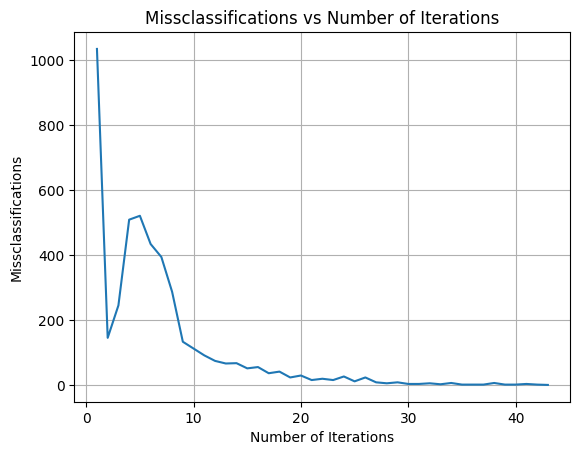

In [14]:
# Visualizing missclassifications vs num_iterations
plt.plot(range(1, len(missclassifications) + 1), missclassifications)
plt.xlabel('Number of Iterations')
plt.ylabel('Missclassifications')
plt.title('Missclassifications vs Number of Iterations')
plt.grid(True)
plt.show()

In [15]:
def get_accuracy(X, y, X_train, alpha):
    m = X.shape[0]
    n = X_train.shape[0]
    print(f"Total number of test samples: {m}")

    miss = 0
    for i in range(m):
        ksum = 0
        for j in range(n):
            # Use the same kernel as defined during kernel matrix
            ksum += alpha[j]*rbf_kernel(X[i], X_train[j], 1.5)
            
        Z = y[i]*ksum
        
        if (Z[0] <= 0):
            miss += 1
    
    print(f"Number of missclassified samples: {miss}")

    return (m-miss)/m

In [16]:
# Tuning hyperparameters using validation set
accuracy = get_accuracy(X_val, y_val, X_train, alpha)
print(f"Accuracy on validation set: {accuracy}")

Total number of test samples: 129
Number of missclassified samples: 12
Accuracy on validation set: 0.9069767441860465


In [17]:
# Training on both train and validation dataset
X_train_val = np.concatenate((X_train, X_val))
y_train_val = np.concatenate((y_train, y_val))

# Defining the kernel matrix
num_samples = len(X_train_val)
K = np.zeros((num_samples,num_samples))

for i in range(num_samples):
    for j in range(num_samples):
        K[i][j] = rbf_kernel(X_train_val[i], X_train_val[j], 1.5)

# Defining the alpha vector
alpha = np.zeros((num_samples,1))

In [18]:

alpha, missclassifications = fit(X_train_val, y_train_val, alpha, K)

Iteration 0: 1164 missclassifications
Iteration 10: 90 missclassifications
Iteration 20: 27 missclassifications
Iteration 30: 3 missclassifications
Iteration 40: 4 missclassifications
Iteration 45: Converged!


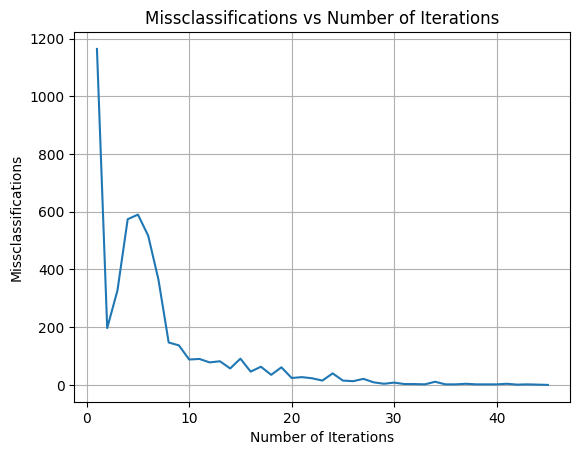

In [19]:
# Visualizing missclassifications vs num_iterations
plt.plot(range(1, len(missclassifications) + 1), missclassifications)
plt.xlabel('Number of Iterations')
plt.ylabel('Missclassifications')
plt.title('Missclassifications vs Number of Iterations')
plt.grid(True)
plt.show()

In [20]:
# Tuning hyperparameters using validation set
accuracy = get_accuracy(X_test, y_test, X_train_val, alpha)
print(f"Accuracy on test set: {accuracy}")

Total number of test samples: 130
Number of missclassified samples: 15
Accuracy on test set: 0.8846153846153846


In [21]:
def predict(test_name):
    # Convert name to feature vector

    name = test_name.lower()

    vec = np.zeros(num_feats)
    vec[num_feats-1] = 1   # Initialize bias term as 1

    # Consider last character of name
    vec[ord(name[-1]) - 97] += 1

    # Consider all bigrams
    for i in range(len(name)-1):
        bigram = name[i:i+2]
        vec[26 + (ord(bigram[0]) - 97)*26 + (ord(bigram[1]) - 97)] += 1
    
    ksum = 0
    for i in range(len(X_train_val)):
        ksum += alpha[i]*rbf_kernel(vec, X_train_val[i], 1.5)

    if ksum > 0:
        print("I am sure " + test_name + " is a boy.")
    elif ksum < 0:
        print("I am sure " + test_name + " is a girl.")
    else:
        print("I am not sure if " + test_name + " is a boy or a girl.")

In [22]:
# Testing with our own example
predict("Aarush")
predict("Aarushi")

I am sure Aarush is a boy.
I am sure Aarushi is a girl.
